#### **Problem №2: Quadrotor Attitude**

Consider the model of quadrotor:
<p align="center">
<img src="https://drive.google.com/uc?id=1S2ZENdiebtmfD4RGuv3mUAVXWoZpAEDL" alt="drawing" width="50%" style="margin:auto"/>
</p>

Follow the steps below:

* **[10 points]** Derive the dynamics of the drone using the propeller speeds $\Omega_i > 0$ as input (recall the lecture on a single rigid body).

* **[10 points]** Simulate the attitude using normalized quaternions and a 4th-order Runge-Kutta algorithm given random propeller speeds, simulate and animate the motion (recall [practice 3](https://docs.google.com/document/d/134ubHnAKN8aM4MRp0NxQsbsdTSLJSWoZv3mZqFrSRQ/edit)).

* **[20 points]** Deduce the inputs that support rotation around the $x$, $y$, and $z$ axes of the body frame (subsequently), simulate and animate the motion.
---

In [32]:
m = 0.1 # [kg] - mass of the motors 
M = 0.5 # [kg] mass of the drone body
h = 0.08 # [m] high of the body
R = 0.05 # [m] radius of the body
l = 0.3 # [m] length of arm 
k_t = 0.05 # thrust coefficient 
k_m = 0.001 # torque coefficient 

In [33]:
import numpy as np

# transfomration from quaternion to rotation matrix
def quat2rot(q):
    # returns rotation matrix for quaternion
    r00 = q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2
    r01 = 2 * (q[1] * q[2] - q[0] * q[3])
    r02 = 2 * (q[1] * q[3] + q[0] * q[2])

    r10 = 2 * (q[1] * q[2] + q[0] * q[3])
    r11 = q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2
    r12 = 2 * (q[2] * q[3] - q[0] * q[1])

    r20 = 2 * (q[1] * q[3] - q[0] * q[2])
    r21 = 2 * (q[2] * q[3] + q[0] * q[1])
    r22 = q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2

    return np.array([
        [r00, r01, r02],
        [r10, r11, r12],
        [r20, r21, r22],
    ])

def exp_q(q):
    # function returns exp(q)
    tolerance = 1e-17
    v_norm = np.linalg.norm(q[1:])
    vec = q[1:]
    if v_norm > tolerance:
        vec = vec / v_norm
    
    magnitude = np.exp(q[0])
    return np.hstack([[magnitude * np.cos(v_norm)], magnitude * vec * np.sin(v_norm)])

def quat_product(p, q):
    Q = np.array([
        [p[0], -p[1], -p[2], -p[3]],
        [p[1], p[0], -p[3], p[2]],
        [p[2], p[3], p[0], -p[1]],
        [p[3], -p[2], p[1], p[0]],
    ])
    return Q @ q

In [34]:
# dynamics of drone

def dynamics(state, torque, inertia):
    q, omega = state[:4], state[4:]

    Omega = np.array([[0, -omega[0], -omega[1], -omega[2]],
                      [omega[0], 0, omega[2], -omega[1]],
                      [omega[1], -omega[2], 0, omega[0]],
                      [omega[2], omega[1], -omega[0], 0]])

    # torque mapping matrix
    tB = np.array([
        [0, -l*k_t, 0, l*k_t],
        [l*k_t, 0, -l*k_t, 0],
        [-k_m, k_m, -k_m, k_m]
    ]) @ torque

    # vector from center to each motor in body frame
    li = [
        np.array([0, l, 0]),
        np.array([l, 0, 0]),
        np.array([0, -l, 0]),
        np.array([-l, 0, 0])
    ]

    # direction of rotation for each motor
    direction = [1, -1, 1, -1]

    thrust = np.array([0, 0, k_m * np.sum(direction * torque)])

    tB = thrust + np.sum([np.cross(li[i], np.array([0, 0, k_t * torque[i]]))
                         for i in range(4)], axis=0)

    dq = Omega @ q / 2
    domega = np.linalg.inv(inertia) @ (tB - np.cross(omega, inertia @ omega))

    return np.hstack((dq, domega))


tf = 5
freq = 100
dT = 1/freq
N = int(tf*freq)

t = np.linspace(0, tf, N)

# initial state
x = np.array([1., 0., 0., 0.,  # initial quaternion
              0.0, 0.0, 0.0])  # initial angular speed

# system parameters
inertia_cyl = np.diag([1/12*M*(3*R**2 + h**2), 1/12 *
                      M*(3*R**2 + h**2), 1/2*M*R**2])

inertia_motor = np.diag([2 * m * l**2, 2 * m * l**2, 4 * m * l**2])

inertia = inertia_cyl + inertia_motor

# control input
# torque = np.array([0.5, 0.5, 0.5, 0.5])

# rotation around Z
# torque = np.array([0.5, -0.5, 0.5, -0.5])

# rotation around X
torque = np.array([1 + 1e-1, 1e-1, -1 + 1e-1, 1e-1])

# rotation around Y
# torque = np.array([0, 1, 0, -1])

# simulation
trajectory = np.zeros((N, 7))

for i in range(N):
    trajectory[i] = x

    xk = x
    k1 = dynamics(x, torque, inertia)
    k2 = dynamics(x + k1 * dT / 2, torque, inertia)
    k3 = dynamics(x + k2 * dT / 2, torque, inertia)
    k4 = dynamics(x + k3 * dT, torque, inertia)

    x = xk + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4) * dT

    # apply normalization to quaternion
    x[:4] = x[:4] / np.linalg.norm(x[:4])


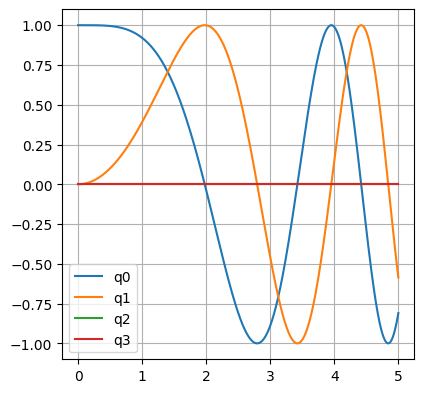

In [35]:
# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(t, trajectory[:, 0], label='q0')
plt.plot(t, trajectory[:, 1], label='q1')
plt.plot(t, trajectory[:, 2], label='q2')
plt.plot(t, trajectory[:, 3], label='q3')
plt.legend()
plt.grid()



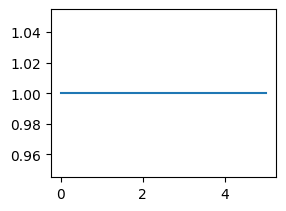

In [36]:
# plot norm of quaternion

plt.subplot(2, 2, 2)
plt.plot(t, np.linalg.norm(trajectory[:, :4], axis=1))

In [37]:
rm = np.zeros((N, 3, 3))
for i in range(N):
    rm[i] = quat2rot(trajectory[i, :4])


In [38]:
import json
with open('vis-data/problem2_X2.json', 'w') as f:
    output = np.hstack([t.reshape(-1, 1), rm.reshape(-1, 9)])

    json.dump(output.tolist(), f)

# from visualize import visualize_rotation

# visualize_rotation(rm, "problem2", [], show=False)